In [73]:
import regex as re

import numpy as np
import matplotlib.pyplot as plt

In [197]:
with open("cbow_corp_001.txt", encoding="utf-8") as file:
    corpus = file.read()
    
# sample of the corpus
corpus[:1000]

'\ufeffThe Project Gutenberg eBook of Pride and Prejudice\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org. If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.\n\nTitle: Pride and Prejudice\n\n\nAuthor: Jane Austen\n\nRelease date: June 1, 1998 [eBook #1342]\n                Most recently updated: April 14, 2023\n\nLanguage: English\n\nCredits: Chuck Greif and the Online Distributed Proofreading Team at http://www.pgdp.net (This file was produced from images available at The Internet Archive)\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE ***\n\n\n\n\n\n                            [Illustration:\n\n                     

In [198]:
def tokenize(corpus):
    # simple tokenizer
    pattern = re.compile(r'[A-Za-z]+')
    return pattern.findall(corpus.lower())

# tokenize the corpus
tokens = tokenize(corpus)
# vocabulary (set of unique words)
vocab = set(tokens)
# vocabulary size
vocab_size = len(vocab)

id2token = {i: t for i, t in enumerate(vocab)}
token2id = {t: i for i, t in enumerate(vocab)}

def encode(token, token2id):
    # create a one-hot vector
    idx = token2id[token]
    vector = [0] * vocab_size
    vector[idx] = 1
    return np.array(vector)


print("vocab size:", vocab_size)

vocab size: 6982


```text
    objective:
        based on the given context try to predict the center word,
        training the neural net on this objective going to build
        a word representaion (word embeddings) hopefully.

    preparing the training data:
        [0, 0, 1, 0, ..., 0] -> 'context word(i-2)'
        [0, 1, 0, 0, ..., 0] -> 'context word(i-1)'
        [1, 0, 0, 0, ..., 0] -> 'context word(i+1)'
        [0, 0, 0, 0, ..., 1] -> 'context word(i+2)'

        compined vectors:
        [1, 1, 1, 1, ..., 1] -> 'context words' # this is going to be the input

        center word:
        [0, 0, 0, 0, ..., 0] -> 'center word' # to be predicted

        NOTE: values in vectors just for demo

```

In [199]:
def build_data(tokens, window_size=2):
    # training data consists of 
    # context words and center words
    # where the model learns to predict
    # the center word from the context words
    contexts = []
    centers = []
    for i in range(len(tokens)):
        # context per current center word
        # to save the context words and combine them
        # into single vector per center word
        context = []
        for j in range(max(0, i-window_size), min(len(tokens), i+window_size+1)):
            if i != j:
                # encode context word
                context.append(encode(tokens[j], token2id))
        # encode center word
        centers.append(encode(tokens[i], token2id))
        # combine context words into single vector
        contexts.append(np.sum(context, axis=0))
        
    return np.array(contexts), np.array(centers)

In [200]:
# build the training data
contexts, centers = build_data(tokens)
print("contexts:", contexts.shape)
print("centers:", centers.shape)

contexts: (131622, 6982)
centers: (131622, 6982)


In [246]:
class CBOWModel:
    def __init__(self, vocab_size, embedding_size):
        # initialize the weights
        self.w1 = np.random.randn(vocab_size, embedding_size)
        self.w2 = np.random.randn(embedding_size, vocab_size)
        assert self.w1.shape[1] == self.w2.shape[0]

    def train(self, contexts, centers, epochs=3, batch_size=8000, lr=0.025):
        losses = []
        num_steps = len(contexts) // batch_size
        for epoch in range(epochs):
            loss = 0
            for step in range(1, num_steps-1):
                # forward pass
                self._forward(contexts[(step-1)*100:step * 100])
                # softmax activation 
                predictions = self._softmax(self.a2)
                # backward pass
                self._backward(centers[(step-1)*100:step * 100], predictions, contexts[(step-1)*100:step * 100], lr)
                # compute loss
                assert predictions.shape == centers[(step-1)*100:step * 100].shape
                loss += self._cross_entropy(centers[(step-1)*100:step * 100], predictions)
                print(f"step: {step:03d}/{num_steps} -- loss: {loss:03f}")
            losses.append(loss)
            print(f"epoch: {epoch:03d}/{epochs} -- loss: {loss:03f}")

        return losses

    def _forward(self, contexts):
        assert contexts.shape[1] == self.w1.shape[0]
        self.a1 = np.dot(contexts, self.w1) # out shape: (N, embed_size)
        assert self.a1.shape[1] == self.w2.shape[0]
        self.a2 = np.dot(self.a1, self.w2) # out shape: (N, vocab)

    def _backward(self, actual, predictions, contexts, lr):
        loss_grad = predictions - actual
        # derivative W2
        w2_grad = np.dot(self.a1.T, loss_grad)
        # derivative W1
        w1_grad = np.dot(contexts.T, np.dot(loss_grad, self.w2.T))
        # shape validation
        assert w2_grad.shape == self.w2.shape
        assert w1_grad.shape == self.w1.shape
        # update weights
        self.w1 -= lr * w1_grad
        self.w2 -= lr * w2_grad

    def _softmax(self, a):
        # for numerical stability
        # avoide numerical overflow
        a = a - np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a)
        return exp_a / np.sum(exp_a, axis=1, keepdims=True)
        
    def _cross_entropy(self, actual, prediction, epsilon=1e-10):
        prediction = np.clip(prediction, epsilon, 1 - epsilon)
        return - np.sum(actual * np.log(prediction))

In [268]:
np.random.seed(42)

model = CBOWModel(vocab_size, 50)
history = model.train(contexts, centers, epochs=10, lr=0.05)

step: 001/16 -- loss: 2285.564224
step: 002/16 -- loss: 4519.645042
step: 003/16 -- loss: 6752.388771
step: 004/16 -- loss: 8941.756530
step: 005/16 -- loss: 11172.706840
step: 006/16 -- loss: 13408.247005
step: 007/16 -- loss: 15638.308576
step: 008/16 -- loss: 17868.045857
step: 009/16 -- loss: 20060.202975
step: 010/16 -- loss: 22331.420131
step: 011/16 -- loss: 24449.923038
step: 012/16 -- loss: 26719.347699
step: 013/16 -- loss: 28975.234641
step: 014/16 -- loss: 31202.753072
epoch: 000/10 -- loss: 31202.753072
step: 001/16 -- loss: 1796.234340
step: 002/16 -- loss: 3575.075287
step: 003/16 -- loss: 5548.974154
step: 004/16 -- loss: 7494.697730
step: 005/16 -- loss: 9297.084865
step: 006/16 -- loss: 11029.387361
step: 007/16 -- loss: 12844.304054
step: 008/16 -- loss: 14750.095744
step: 009/16 -- loss: 16638.029433
step: 010/16 -- loss: 18659.839500
step: 011/16 -- loss: 20483.236451
step: 012/16 -- loss: 22308.157747
step: 013/16 -- loss: 24111.131299
step: 014/16 -- loss: 25975.

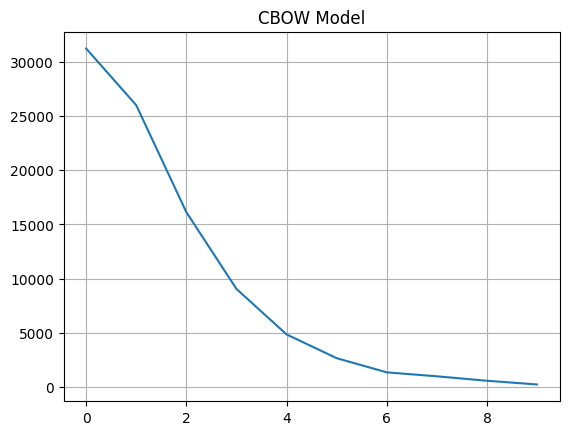

In [269]:
plt.title("CBOW Model")
plt.plot([i for i in range(len(history))], history)
plt.grid()
plt.show()

In [257]:
def get_relevant_words(w):
    token_id = token2id[w]
    similarites = np.dot(model.w1, model.w1[token_id])
    most_similar = np.argsort(similarites)[::-1][:10]
    
    for i, tid in enumerate(most_similar):
        print(f"word #{i}: {id2token[tid]}")

In [267]:
get_relevant_words("seats")

word #0: seats
word #1: charming
word #2: joined
word #3: revealing
word #4: preparations
word #5: diffuseness
word #6: she
word #7: elder
word #8: entrain
word #9: robinson
